In [1]:
# =============================================================================
# SETUP AND IMPORTS
# =============================================================================
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import sys
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Project paths
repo_root = Path.cwd().parent
src_path = repo_root / "src"
scripts_path = repo_root / "scripts"
data_path = repo_root / "data"
results_path = repo_root / "results"

# Add paths
sys.path.insert(0, str(src_path))
sys.path.insert(1, str(scripts_path))

# Import our modules
import network_clust as netclust

# Check Gurobi availability
try:
    import gurobipy as gp
    GUROBI_AVAILABLE = True
    print(f"✓ Gurobi version: {gp.gurobi.version()}")
except ImportError:
    GUROBI_AVAILABLE = False
    print("⚠ Gurobi not available - will use HiGHS solver")

print(f"\nPyPSA version: {pypsa.__version__}")
print(f"Project root: {repo_root}")

✓ Gurobi version: (13, 0, 0)

PyPSA version: 1.0.5
Project root: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model


## 1. Configuration

In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Network file
NETWORK_FILE = "O+_sEEN_2023-01-01.nc"

# Solver configuration
SOLVER_NAME = 'gurobi' if GUROBI_AVAILABLE else 'highs'

# Gurobi solver options
GUROBI_OPTIONS = {
    'MIPGap': 0.01,            # 1% optimality gap
    'TimeLimit': 7200,         # 2 hour time limit
    'Threads': 10,             # Number of threads
    'Method': 2,               # Barrier method (2) for LP
    'Crossover': 0,            # No crossover (faster for LP)
    'BarHomogeneous': 1,       # Homogeneous algorithm
    'OutputFlag': 1,           # Show solver output
}

# HiGHS fallback options
HIGHS_OPTIONS = {
    'threads': 4,
    'time_limit': 7200,
}

SOLVER_OPTIONS = GUROBI_OPTIONS if SOLVER_NAME == 'gurobi' else HIGHS_OPTIONS

# CO2 emission factors (tonnes CO2 per MWh electrical)
CO2_FACTORS = {
    'lignite': 0.41 / 0.35,    # ~1.17 tCO2/MWh
    'hard coal': 0.35 / 0.38,  # ~0.92 tCO2/MWh
    'gas': 0.20 / 0.50,        # ~0.40 tCO2/MWh
    'oil': 0.27 / 0.35,        # ~0.77 tCO2/MWh
}

print(f"Solver: {SOLVER_NAME}")
print(f"Network: {NETWORK_FILE}")

Solver: gurobi
Network: O+_sEEN_2023-01-01.nc


## 2. Load Network

In [3]:
# =============================================================================
# LOAD NETWORK
# =============================================================================

network_path = data_path / "networks" / "optimize" / NETWORK_FILE

if not network_path.exists():
    raise FileNotFoundError(f"Network not found: {network_path}\nPlease run network_05.ipynb first.")

n = pypsa.Network(str(network_path))

print(f"Loaded network: {network_path.name}")
print(f"\n{'='*50}")
print("NETWORK STRUCTURE")
print(f"{'='*50}")
print(f"  Buses: {len(n.buses)}")
print(f"  Lines: {len(n.lines)}")
print(f"  Links: {len(n.links)}")
print(f"  Generators: {len(n.generators)}")
print(f"  Loads: {len(n.loads)}")
print(f"  Snapshots: {len(n.snapshots)}")
print(f"  Period: {n.snapshots[0]} to {n.snapshots[-1]}")

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, sub_networks


Loaded network: O+_sEEN_2023-01-01.nc

NETWORK STRUCTURE
  Buses: 200
  Lines: 237
  Links: 28
  Generators: 8156
  Loads: 6258
  Snapshots: 168
  Period: 2023-01-01 00:00:00 to 2023-01-07 23:00:00


## 3. Apply Connectivity Fixes

Fix common issues:
- Make all links bidirectional (`p_min_pu = -1`)
- Handle isolated buses

In [4]:
# =============================================================================
# APPLY CONNECTIVITY FIXES
# =============================================================================

# Check link bidirectionality before fix
n_unidirectional_before = (n.links['p_min_pu'] >= 0).sum()
n_bidirectional_before = (n.links['p_min_pu'] < 0).sum()

print(f"BEFORE FIX:")
print(f"  Unidirectional links: {n_unidirectional_before}")
print(f"  Bidirectional links: {n_bidirectional_before}")

# Apply fixes using our module
fixes = netclust.fix_post_clustering_connectivity(
    n,
    simplified_network=None,
    remove_truly_isolated=True,
    reconnect_link_isolated=False,
    ensure_bidirectional=True
)

# Verify
n_unidirectional_after = (n.links['p_min_pu'] >= 0).sum()
n_bidirectional_after = (n.links['p_min_pu'] < 0).sum()

print(f"\nAFTER FIX:")
print(f"  Unidirectional links: {n_unidirectional_after}")
print(f"  Bidirectional links: {n_bidirectional_after}")
print(f"\n✓ All links can now transfer power in both directions")

INFO:network_clust:============================================================
INFO:network_clust:POST-CLUSTERING CONNECTIVITY FIXES
INFO:network_clust:============================================================
INFO:network_clust:Made 28 links bidirectional (p_min_pu = -1.0)
INFO:network_clust:Isolated bus analysis:
INFO:network_clust:  Total isolated (no lines): 65
INFO:network_clust:  Already isolated (no links): 14
INFO:network_clust:  Newly isolated (has links): 51
INFO:network_clust:Removed 14 isolated buses
INFO:network_clust:============================================================
INFO:network_clust:CONNECTIVITY FIXES COMPLETE
INFO:network_clust:  Links made bidirectional: 28
INFO:network_clust:  Isolated buses removed: 14
INFO:network_clust:  Buses reconnected: 0
INFO:network_clust:============================================================


BEFORE FIX:
  Unidirectional links: 28
  Bidirectional links: 0

AFTER FIX:
  Unidirectional links: 0
  Bidirectional links: 28

✓ All links can now transfer power in both directions


In [8]:
# =============================================================================
# ADDITIONAL FIX: ADD SLACK GENERATORS TO ISOLATED BUSES
# =============================================================================
# Buses connected only via links need a backup generation source
# to handle cases where the link cannot import enough power

# Find buses with no line connections
buses_in_lines = set(n.lines.bus0) | set(n.lines.bus1)
buses_only_in_links = set(n.buses.index) - buses_in_lines

print(f"Buses connected only via links: {len(buses_only_in_links)}")

# For each such bus, check if it has sufficient local generation
slack_added = []
for bus in buses_only_in_links:
    # Get loads at this bus
    bus_loads = n.loads[n.loads.bus == bus]
    if len(bus_loads) == 0:
        continue
    
    # Calculate peak demand
    if bus_loads.index[0] in n.loads_t.p_set.columns:
        peak_demand = n.loads_t.p_set[bus_loads.index].sum(axis=1).max()
    else:
        peak_demand = bus_loads.p_set.sum()
    
    # Get local generation capacity
    bus_gens = n.generators[n.generators.bus == bus]
    local_capacity = bus_gens.p_nom.sum() if len(bus_gens) > 0 else 0
    
    # Get link capacity (for import)
    bus_links = n.links[(n.links.bus0 == bus) | (n.links.bus1 == bus)]
    link_capacity = bus_links.p_nom.sum() if len(bus_links) > 0 else 0
    
    # If local + link capacity < 1.2x peak demand, add slack
    total_supply = local_capacity + link_capacity
    if total_supply < peak_demand * 1.2:
        slack_name = f"slack_{bus}"
        if slack_name not in n.generators.index:
            slack_capacity = peak_demand * 1.2 - total_supply + 100  # Add margin
            n.add(
                "Generator",
                slack_name,
                bus=bus,
                p_nom=slack_capacity,
                marginal_cost=10000,  # Very high cost (load shedding)
                carrier="load_shedding"
            )
            slack_added.append((bus, slack_capacity))

# Add load_shedding carrier if not exists
if 'load_shedding' not in n.carriers.index:
    n.add("Carrier", "load_shedding", co2_emissions=0, nice_name="Load Shedding")

print(f"\nAdded {len(slack_added)} slack generators for load shedding:")
for bus, cap in slack_added[:10]:
    print(f"  {bus}: {cap:.1f} MW")
if len(slack_added) > 10:
    print(f"  ... and {len(slack_added)-10} more")

Buses connected only via links: 51

Added 0 slack generators for load shedding:


In [11]:
# =============================================================================
# DIAGNOSE INFEASIBILITY
# =============================================================================
import networkx as nx

# Build graph including both lines and links
G = nx.Graph()
G.add_nodes_from(n.buses.index)
for _, line in n.lines.iterrows():
    G.add_edge(line.bus0, line.bus1, type='line')
for _, link in n.links.iterrows():
    G.add_edge(link.bus0, link.bus1, type='link')

# Find connected components
components = list(nx.connected_components(G))
print(f"Number of connected components (lines + links): {len(components)}")

# The problem: 28 separate components! That's why it's infeasible.
# Each isolated component can't balance independently if they don't have
# enough generation to match load

print("\nComponents by size (showing issues):")
small_components_with_issues = []
for i, comp in enumerate(sorted(components, key=len, reverse=True)):
    comp_buses = list(comp)
    
    # Check load and generation in this component
    comp_loads = n.loads[n.loads.bus.isin(comp_buses)]
    comp_gens = n.generators[n.generators.bus.isin(comp_buses)]
    
    # Calculate total load energy
    if len(comp_loads) > 0:
        valid_load_cols = [c for c in comp_loads.index if c in n.loads_t.p_set.columns]
        if valid_load_cols:
            load_sum = n.loads_t.p_set[valid_load_cols].sum().sum()
        else:
            load_sum = comp_loads.p_set.sum() * len(n.snapshots)
    else:
        load_sum = 0
    
    # Calculate max generation potential
    if len(comp_gens) > 0:
        # Get generators with time-varying profiles
        valid_gen_cols = [g for g in comp_gens.index if g in n.generators_t.p_max_pu.columns]
        if valid_gen_cols:
            gen_energy = (n.generators_t.p_max_pu[valid_gen_cols] * comp_gens.loc[valid_gen_cols, 'p_nom']).sum().sum()
        else:
            gen_energy = 0
        # Add static generators
        static_gens = [g for g in comp_gens.index if g not in n.generators_t.p_max_pu.columns]
        if static_gens:
            gen_energy += comp_gens.loc[static_gens, 'p_nom'].sum() * len(n.snapshots)
        gen_cap = comp_gens.p_nom.sum()
    else:
        gen_energy = 0
        gen_cap = 0
    
    # Print info for components with issues
    if len(comp) < 20 or load_sum > gen_energy * 1.1:
        small_components_with_issues.append({
            'comp_id': i+1,
            'buses': len(comp),
            'load_MWh': load_sum,
            'gen_energy_MWh': gen_energy,
            'gen_cap_MW': gen_cap,
            'deficit': load_sum - gen_energy,
            'sample_buses': list(comp)[:3]
        })

print(f"\nFound {len(small_components_with_issues)} components with potential issues:")
if small_components_with_issues:
    df = pd.DataFrame(small_components_with_issues)
    print(df[['comp_id', 'buses', 'load_MWh', 'gen_energy_MWh', 'gen_cap_MW', 'deficit']].to_string())
    
    # Show sample buses from problematic small components
    print("\nSample buses from small components:")
    for comp in small_components_with_issues[:5]:
        if comp['buses'] < 10:
            print(f"  Component {comp['comp_id']}: {comp['sample_buses']}")

Number of connected components (lines + links): 28

Components by size (showing issues):

Found 27 components with potential issues:
    comp_id  buses   load_MWh  gen_energy_MWh    gen_cap_MW       deficit
0         2     10  2956820.0    9.624150e+06  82631.303730 -6.667330e+06
1         3      4   658045.0    2.403693e+06  20486.288633 -1.745648e+06
2         4      3    28444.0    2.310050e+05   1717.690000 -2.025610e+05
3         5      3     1739.0    1.847815e+06  11540.703232 -1.846076e+06
4         6      3    68109.0    6.557917e+05   4744.401436 -5.876827e+05
5         7      3        0.0    5.689839e+06  48743.247070 -5.689839e+06
6         8      2     9570.0    2.057179e+06  13798.337568 -2.047609e+06
7         9      2    23961.0    1.255911e+06  12572.200000 -1.231950e+06
8        10      2    19416.0    1.013544e+06   9114.342410 -9.941281e+05
9        11      2      627.0    1.447590e+06  13915.837405 -1.446963e+06
10       12      2    20780.0    8.075803e+05   6623.

In [12]:
# =============================================================================
# FIX: CONNECT ISOLATED COMPONENTS VIA VIRTUAL LINES
# =============================================================================
# Each component that's connected via links but isolated from the main grid
# needs a virtual line to allow power balancing through the interconnectors

# Find the main component (largest)
main_component = max(components, key=len)
main_buses = set(main_component)

print(f"Main component has {len(main_component)} buses")
print(f"Isolated components: {len(components) - 1}")

# For each isolated component, find the best connection point and add virtual line
virtual_lines_added = []

for comp in components:
    if comp == main_component:
        continue
    
    comp_buses = list(comp)
    
    # Find buses in this component that have links
    for bus in comp_buses:
        # Check links from this bus
        links_from = n.links[n.links.bus0 == bus]
        links_to = n.links[n.links.bus1 == bus]
        
        # Check if any link connects to main component
        for _, link in pd.concat([links_from, links_to]).iterrows():
            other_bus = link.bus1 if link.bus0 == bus else link.bus0
            
            if other_bus in main_buses:
                # Add virtual line to connect via this link's endpoints
                # This allows power to flow through the link
                line_name = f"virtual_link_conn_{bus}_{other_bus}"
                if line_name not in n.lines.index:
                    # Use high capacity, low impedance (virtual connection)
                    n.add(
                        "Line",
                        line_name,
                        bus0=bus,
                        bus1=other_bus,
                        s_nom=link.p_nom * 10,  # High capacity virtual line
                        x=0.0001,  # Very low reactance
                        r=0.0001,
                        length=1,  # Minimal length
                        carrier='AC',
                    )
                    virtual_lines_added.append((bus, other_bus, link.p_nom))
                    break  # One connection per isolated bus is enough
        
        if len(virtual_lines_added) > 0 and virtual_lines_added[-1][0] in comp_buses:
            break  # Move to next component after connecting this one

# Also connect components that have NO links to main (truly isolated)
# by finding nearest bus in main component
from scipy.spatial.distance import cdist

isolated_buses_no_link = set()
for comp in components:
    if comp == main_component:
        continue
    comp_buses = list(comp)
    
    # Check if already connected
    already_connected = any(bus in [v[0] for v in virtual_lines_added] for bus in comp_buses)
    if already_connected:
        continue
    
    # Find nearest bus in main component
    comp_coords = n.buses.loc[comp_buses, ['x', 'y']].values
    main_coords = n.buses.loc[list(main_buses), ['x', 'y']].values
    
    distances = cdist(comp_coords, main_coords)
    min_idx = np.unravel_index(distances.argmin(), distances.shape)
    
    bus_from = comp_buses[min_idx[0]]
    bus_to = list(main_buses)[min_idx[1]]
    
    line_name = f"virtual_geo_conn_{bus_from}_{bus_to}"
    if line_name not in n.lines.index:
        n.add(
            "Line",
            line_name,
            bus0=bus_from,
            bus1=bus_to,
            s_nom=10000,  # 10 GW virtual capacity
            x=0.0001,
            r=0.0001,
            length=1,
            carrier='AC',
        )
        virtual_lines_added.append((bus_from, bus_to, 10000))

print(f"\nAdded {len(virtual_lines_added)} virtual lines to connect isolated components:")
for bus0, bus1, cap in virtual_lines_added[:10]:
    print(f"  {bus0} <-> {bus1} ({cap:.0f} MW)")
if len(virtual_lines_added) > 10:
    print(f"  ... and {len(virtual_lines_added) - 10} more")

# Verify connectivity
G2 = nx.Graph()
G2.add_nodes_from(n.buses.index)
for _, line in n.lines.iterrows():
    G2.add_edge(line.bus0, line.bus1)
for _, link in n.links.iterrows():
    G2.add_edge(link.bus0, link.bus1)
    
new_components = list(nx.connected_components(G2))
print(f"\nAfter fix: {len(new_components)} connected component(s)")

Main component has 118 buses
Isolated components: 27

Added 27 virtual lines to connect isolated components:
  BE20 0 <-> BE0 0 (10000 MW)
  BE53 0 <-> BE0 1 (10000 MW)
  DE50 0 <-> DE0 16 (10000 MW)
  DE54 0 <-> DE0 16 (10000 MW)
  DE66 0 <-> DE0 18 (10000 MW)
  DK1 0 <-> DE0 18 (10000 MW)
  DK17 0 <-> DK0 0 (10000 MW)
  DK27 0 <-> DK0 1 (10000 MW)
  DK67 0 <-> DK0 1 (10000 MW)
  DK68 0 <-> DK0 2 (10000 MW)
  ... and 17 more

After fix: 1 connected component(s)


## 4. Network Validation

In [13]:
# =============================================================================
# VALIDATE NETWORK
# =============================================================================

def validate_network(network):
    """Validate network is ready for optimization."""
    issues = []
    
    # Check for negative capacities
    if (network.generators.p_nom < 0).any():
        issues.append(f"Negative generator capacities: {(network.generators.p_nom < 0).sum()}")
    
    if (network.lines.s_nom < 0).any():
        issues.append(f"Negative line capacities: {(network.lines.s_nom < 0).sum()}")
    
    # Check for zero line capacities
    zero_lines = (network.lines.s_nom == 0).sum()
    if zero_lines > 0:
        issues.append(f"Zero capacity lines: {zero_lines}")
    
    # Check generator carriers
    gen_carriers = set(network.generators.carrier.unique())
    defined_carriers = set(network.carriers.index)
    missing = gen_carriers - defined_carriers - {''}
    if missing:
        issues.append(f"Generators with undefined carriers: {missing}")
    
    # Check for loads with no snapshots
    if len(network.loads_t.p_set.columns) == 0 and len(network.loads) > 0:
        # Check static loads
        static_loads = network.loads[network.loads.p_set > 0]
        if len(static_loads) == 0:
            issues.append("No time-varying or static loads found")
    
    # Check total capacity vs load
    total_gen_cap = network.generators.p_nom.sum()
    total_load = network.loads_t.p_set.sum().sum() if len(network.loads_t.p_set.columns) > 0 else network.loads.p_set.sum() * len(network.snapshots)
    avg_load = total_load / len(network.snapshots) if len(network.snapshots) > 0 else 0
    
    if total_gen_cap < avg_load * 0.5:
        issues.append(f"Generator capacity ({total_gen_cap/1e3:.1f} GW) < 50% of avg load ({avg_load/1e3:.1f} GW)")
    
    return issues

# Run validation
print("NETWORK VALIDATION")
print("="*50)

issues = validate_network(n)

if issues:
    print("⚠ Issues found:")
    for issue in issues:
        print(f"  - {issue}")
else:
    print("✓ Network passed all validation checks")

# Print summary statistics
print(f"\nSUMMARY STATISTICS")
print("-"*50)
print(f"Total generation capacity: {n.generators.p_nom.sum()/1e3:.1f} GW")
print(f"Total line capacity: {n.lines.s_nom.sum()/1e3:.1f} GW")
print(f"Total link capacity: {n.links.p_nom.sum()/1e3:.1f} GW")

# Generation by carrier
print(f"\nGeneration capacity by carrier (GW):")
gen_by_carrier = n.generators.groupby('carrier').p_nom.sum().sort_values(ascending=False) / 1e3
for carrier, cap in gen_by_carrier.head(10).items():
    print(f"  {carrier:15s}: {cap:8.2f} GW")

NETWORK VALIDATION
✓ Network passed all validation checks

SUMMARY STATISTICS
--------------------------------------------------
Total generation capacity: 1284.7 GW
Total line capacity: 1566.2 GW
Total link capacity: 23.3 GW

Generation capacity by carrier (GW):
  wind           :   286.88 GW
  gas            :   242.33 GW
  hydro          :   207.74 GW
  nuclear        :   154.41 GW
  hard coal      :   148.55 GW
  solar          :   131.95 GW
  lignite        :    60.74 GW
  oil            :    21.52 GW
  biomass        :    17.92 GW
  other          :     4.45 GW


## 5. Run Dispatch Optimization

Optimize power plant dispatch with fixed capacities to minimize total system cost.

In [14]:
# =============================================================================
# PREPARE DISPATCH OPTIMIZATION
# =============================================================================

# Make a copy for dispatch optimization
n_dispatch = n.copy()

# Ensure all generators are NOT extendable (dispatch only)
n_dispatch.generators['p_nom_extendable'] = False
n_dispatch.lines['s_nom_extendable'] = False
n_dispatch.links['p_nom_extendable'] = False

print("DISPATCH OPTIMIZATION SETUP")
print("="*50)
print(f"Snapshots: {len(n_dispatch.snapshots)}")
print(f"Generators: {len(n_dispatch.generators)}")
print(f"Extendable generators: {n_dispatch.generators.p_nom_extendable.sum()}")
print(f"Solver: {SOLVER_NAME}")

DISPATCH OPTIMIZATION SETUP
Snapshots: 168
Generators: 8156
Extendable generators: 0
Solver: gurobi


In [15]:
# =============================================================================
# RUN DISPATCH OPTIMIZATION
# =============================================================================

print("Running dispatch optimization...")
print("="*50)

import time
start_time = time.time()

status, termination_condition = n_dispatch.optimize(
    solver_name=SOLVER_NAME,
    solver_options=SOLVER_OPTIONS,
)

elapsed = time.time() - start_time

print(f"\nOPTIMIZATION RESULTS")
print("="*50)
print(f"Status: {status}")
print(f"Termination: {termination_condition}")
print(f"Runtime: {elapsed:.1f} seconds")

if status == 'ok':
    print(f"\nObjective value (total cost): {n_dispatch.objective/1e6:.2f} M€")
    print("✓ Optimization completed successfully!")
else:
    print("\n⚠ Optimization did not converge successfully")

Running dispatch optimization...


carrier
AC    135
DC     24
Name: count, dtype: int64
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - MIPGap: 0.01
 - TimeLimit: 7200
 - Threads: 10
 - Method: 2
 - Crossover: 0
 - BarHomogeneous: 1
 - OutputFlag: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 24.79it/s]
INFO:linopy.io: Writing time: 2.45s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2755728


INFO:gurobipy:Set parameter LicenseID to value 2755728


Academic license - for non-commercial use only - expires 2026-12-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-12-16


Read LP format model from file /private/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/linopy-problem-kppqra1r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/linopy-problem-kppqra1r.lp


Reading time = 2.46 seconds


INFO:gurobipy:Reading time = 2.46 seconds


obj: 2887584 rows, 1419264 columns, 4406640 nonzeros


INFO:gurobipy:obj: 2887584 rows, 1419264 columns, 4406640 nonzeros


Set parameter MIPGap to value 0.01


INFO:gurobipy:Set parameter MIPGap to value 0.01


Set parameter TimeLimit to value 7200


INFO:gurobipy:Set parameter TimeLimit to value 7200


Set parameter Threads to value 10


INFO:gurobipy:Set parameter Threads to value 10


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Crossover to value 0


INFO:gurobipy:Set parameter Crossover to value 0


Set parameter BarHomogeneous to value 1


INFO:gurobipy:Set parameter BarHomogeneous to value 1


Set parameter OutputFlag to value 1


INFO:gurobipy:Set parameter OutputFlag to value 1


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)


INFO:gurobipy:


CPU model: Apple M3 Pro


INFO:gurobipy:CPU model: Apple M3 Pro


Thread count: 11 physical cores, 11 logical processors, using up to 10 threads


INFO:gurobipy:Thread count: 11 physical cores, 11 logical processors, using up to 10 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


TimeLimit  7200


INFO:gurobipy:TimeLimit  7200


MIPGap  0.01


INFO:gurobipy:MIPGap  0.01


Method  2


INFO:gurobipy:Method  2


BarHomogeneous  1


INFO:gurobipy:BarHomogeneous  1


Crossover  0


INFO:gurobipy:Crossover  0


Threads  10


INFO:gurobipy:Threads  10


INFO:gurobipy:


Optimize a model with 2887584 rows, 1419264 columns and 4406640 nonzeros (Min)


INFO:gurobipy:Optimize a model with 2887584 rows, 1419264 columns and 4406640 nonzeros (Min)


Model fingerprint: 0xea30ecc0


INFO:gurobipy:Model fingerprint: 0xea30ecc0


Model has 627480 linear objective coefficients


INFO:gurobipy:Model has 627480 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [7e-01, 2e+02]


INFO:gurobipy:  Matrix range     [7e-01, 2e+02]


  Objective range  [5e+00, 8e+01]


INFO:gurobipy:  Objective range  [5e+00, 8e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-11, 3e+04]


INFO:gurobipy:  RHS range        [1e-11, 3e+04]


Presolve removed 91483 rows and 1486124 columns


INFO:gurobipy:Presolve removed 91483 rows and 1486124 columns


Presolve time: 2.33s


INFO:gurobipy:Presolve time: 2.33s


Presolved: 1327781 rows, 1401460 columns, 2969898 nonzeros


INFO:gurobipy:Presolved: 1327781 rows, 1401460 columns, 2969898 nonzeros


Ordering time: 1.72s


INFO:gurobipy:Ordering time: 1.72s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 168


INFO:gurobipy: Dense cols : 168


 Free vars  : 17043


INFO:gurobipy: Free vars  : 17043


 AA' NZ     : 6.053e+07


INFO:gurobipy: AA' NZ     : 6.053e+07


 Factor NZ  : 6.209e+07 (roughly 1.5 GB of memory)


INFO:gurobipy: Factor NZ  : 6.209e+07 (roughly 1.5 GB of memory)


 Factor Ops : 5.768e+09 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.768e+09 (less than 1 second per iteration)


 Threads    : 10


INFO:gurobipy: Threads    : 10


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0  -6.50516714e+10  8.03062397e+08  2.39e+02 1.02e+04  1.45e+06     8s


INFO:gurobipy:   0  -6.50516714e+10  8.03062397e+08  2.39e+02 1.02e+04  1.45e+06     8s


   1  -4.32050966e+10  1.99796935e+09  7.81e+01 2.35e+03  3.48e+05     8s


INFO:gurobipy:   1  -4.32050966e+10  1.99796935e+09  7.81e+01 2.35e+03  3.48e+05     8s


   2  -2.30059047e+10  1.46536931e+09  7.48e+00 3.83e+02  6.30e+04     9s


INFO:gurobipy:   2  -2.30059047e+10  1.46536931e+09  7.48e+00 3.83e+02  6.30e+04     9s


   3  -1.14273281e+10  1.26449369e+09  1.85e+00 7.48e+01  1.50e+04     9s


INFO:gurobipy:   3  -1.14273281e+10  1.26449369e+09  1.85e+00 7.48e+01  1.50e+04     9s


   4  -4.82910058e+09  1.07822162e+09  8.57e-01 3.79e+01  6.04e+03     9s


INFO:gurobipy:   4  -4.82910058e+09  1.07822162e+09  8.57e-01 3.79e+01  6.04e+03     9s


   5  -2.98306584e+09  9.92815281e+08  5.57e-01 2.84e+01  3.89e+03    10s


INFO:gurobipy:   5  -2.98306584e+09  9.92815281e+08  5.57e-01 2.84e+01  3.89e+03    10s


   6  -1.53665467e+09  7.49985457e+08  3.21e-01 1.12e+01  1.69e+03    10s


INFO:gurobipy:   6  -1.53665467e+09  7.49985457e+08  3.21e-01 1.12e+01  1.69e+03    10s


   7  -4.00568075e+08  5.68752973e+08  1.25e-01 6.25e+00  6.91e+02    11s


INFO:gurobipy:   7  -4.00568075e+08  5.68752973e+08  1.25e-01 6.25e+00  6.91e+02    11s


   8  -1.50217606e+08  4.36572825e+08  7.86e-02 2.97e+00  3.61e+02    11s


INFO:gurobipy:   8  -1.50217606e+08  4.36572825e+08  7.86e-02 2.97e+00  3.61e+02    11s


   9  -2.72405264e+07  4.13285228e+08  5.67e-02 2.46e+00  2.69e+02    11s


INFO:gurobipy:   9  -2.72405264e+07  4.13285228e+08  5.67e-02 2.46e+00  2.69e+02    11s


  10   8.12330871e+07  3.72567892e+08  3.70e-02 1.63e+00  1.71e+02    12s


INFO:gurobipy:  10   8.12330871e+07  3.72567892e+08  3.70e-02 1.63e+00  1.71e+02    12s


  11   1.52861732e+08  3.29307268e+08  2.37e-02 8.21e-01  9.57e+01    12s


INFO:gurobipy:  11   1.52861732e+08  3.29307268e+08  2.37e-02 8.21e-01  9.57e+01    12s


  12   2.11341498e+08  3.13792502e+08  1.27e-02 5.60e-01  5.52e+01    13s


INFO:gurobipy:  12   2.11341498e+08  3.13792502e+08  1.27e-02 5.60e-01  5.52e+01    13s


  13   2.32886966e+08  2.97459953e+08  8.64e-03 2.95e-01  3.31e+01    13s


INFO:gurobipy:  13   2.32886966e+08  2.97459953e+08  8.64e-03 2.95e-01  3.31e+01    13s


  14   2.46177065e+08  2.93907256e+08  6.09e-03 2.41e-01  2.45e+01    13s


INFO:gurobipy:  14   2.46177065e+08  2.93907256e+08  6.09e-03 2.41e-01  2.45e+01    13s


  15   2.57820261e+08  2.88210748e+08  3.80e-03 1.57e-01  1.54e+01    14s


INFO:gurobipy:  15   2.57820261e+08  2.88210748e+08  3.80e-03 1.57e-01  1.54e+01    14s


  16   2.65718327e+08  2.83366239e+08  2.27e-03 8.57e-02  8.72e+00    14s


INFO:gurobipy:  16   2.65718327e+08  2.83366239e+08  2.27e-03 8.57e-02  8.72e+00    14s


  17   2.70356009e+08  2.81423444e+08  1.37e-03 5.80e-02  5.46e+00    15s


INFO:gurobipy:  17   2.70356009e+08  2.81423444e+08  1.37e-03 5.80e-02  5.46e+00    15s


  18   2.72551751e+08  2.80435719e+08  9.37e-04 4.40e-02  3.89e+00    15s


INFO:gurobipy:  18   2.72551751e+08  2.80435719e+08  9.37e-04 4.40e-02  3.89e+00    15s


  19   2.74357046e+08  2.79464596e+08  5.80e-04 3.04e-02  2.53e+00    15s


INFO:gurobipy:  19   2.74357046e+08  2.79464596e+08  5.80e-04 3.04e-02  2.53e+00    15s


  20   2.75148150e+08  2.78702914e+08  4.22e-04 1.98e-02  1.74e+00    16s


INFO:gurobipy:  20   2.75148150e+08  2.78702914e+08  4.22e-04 1.98e-02  1.74e+00    16s


  21   2.76064870e+08  2.78227368e+08  2.43e-04 1.30e-02  1.06e+00    16s


INFO:gurobipy:  21   2.76064870e+08  2.78227368e+08  2.43e-04 1.30e-02  1.06e+00    16s


  22   2.76725203e+08  2.77711153e+08  4.24e-04 5.85e-03  4.81e-01    17s


INFO:gurobipy:  22   2.76725203e+08  2.77711153e+08  4.24e-04 5.85e-03  4.81e-01    17s


  23   2.77004732e+08  2.77533696e+08  5.41e-04 3.36e-03  2.60e-01    17s


INFO:gurobipy:  23   2.77004732e+08  2.77533696e+08  5.41e-04 3.36e-03  2.60e-01    17s


  24   2.77130417e+08  2.77383794e+08  7.01e-04 1.24e-03  1.21e-01    18s


INFO:gurobipy:  24   2.77130417e+08  2.77383794e+08  7.01e-04 1.24e-03  1.21e-01    18s


  25   2.77227849e+08  2.77362413e+08  7.74e-04 9.38e-04  6.67e-02    18s


INFO:gurobipy:  25   2.77227849e+08  2.77362413e+08  7.74e-04 9.38e-04  6.67e-02    18s


  26   2.77260740e+08  2.77337540e+08  7.95e-04 5.95e-04  3.86e-02    18s


INFO:gurobipy:  26   2.77260740e+08  2.77337540e+08  7.95e-04 5.95e-04  3.86e-02    18s


  27   2.77272631e+08  2.77321659e+08  6.92e-04 3.75e-04  2.46e-02    19s


INFO:gurobipy:  27   2.77272631e+08  2.77321659e+08  6.92e-04 3.75e-04  2.46e-02    19s


  28   2.77283930e+08  2.77307523e+08  7.05e-04 1.80e-04  1.19e-02    19s


INFO:gurobipy:  28   2.77283930e+08  2.77307523e+08  7.05e-04 1.80e-04  1.19e-02    19s


  29   2.77288245e+08  2.77300338e+08  7.07e-04 7.77e-05  5.97e-03    20s


INFO:gurobipy:  29   2.77288245e+08  2.77300338e+08  7.07e-04 7.77e-05  5.97e-03    20s


  30   2.77288954e+08  2.77299931e+08  6.33e-04 7.18e-05  5.43e-03    20s


INFO:gurobipy:  30   2.77288954e+08  2.77299931e+08  6.33e-04 7.18e-05  5.43e-03    20s


  31   2.77289541e+08  2.77299191e+08  5.70e-04 6.12e-05  4.76e-03    21s


INFO:gurobipy:  31   2.77289541e+08  2.77299191e+08  5.70e-04 6.12e-05  4.76e-03    21s


  32   2.77291042e+08  2.77298290e+08  5.52e-04 4.82e-05  3.59e-03    21s


INFO:gurobipy:  32   2.77291042e+08  2.77298290e+08  5.52e-04 4.82e-05  3.59e-03    21s


  33   2.77292206e+08  2.77297259e+08  5.48e-04 3.34e-05  2.51e-03    22s


INFO:gurobipy:  33   2.77292206e+08  2.77297259e+08  5.48e-04 3.34e-05  2.51e-03    22s


  34   2.77294127e+08  2.77296913e+08  4.72e-04 2.85e-05  1.47e-03    23s


INFO:gurobipy:  34   2.77294127e+08  2.77296913e+08  4.72e-04 2.85e-05  1.47e-03    23s


  35   2.77294785e+08  2.77295184e+08  4.65e-04 3.23e-06  2.09e-04    23s


INFO:gurobipy:  35   2.77294785e+08  2.77295184e+08  4.65e-04 3.23e-06  2.09e-04    23s


  36   2.77294786e+08  2.77295183e+08  4.64e-04 3.22e-06  2.08e-04    25s


INFO:gurobipy:  36   2.77294786e+08  2.77295183e+08  4.64e-04 3.22e-06  2.08e-04    25s


  37   2.77294796e+08  2.77295181e+08  4.38e-04 3.19e-06  2.02e-04    25s


INFO:gurobipy:  37   2.77294796e+08  2.77295181e+08  4.38e-04 3.19e-06  2.02e-04    25s


  38   2.77294796e+08  2.77295181e+08  4.38e-04 3.19e-06  1.86e-04    26s


INFO:gurobipy:  38   2.77294796e+08  2.77295181e+08  4.38e-04 3.19e-06  1.86e-04    26s


  39   2.77294821e+08  2.77295170e+08  3.73e-04 3.03e-06  1.69e-04    27s


INFO:gurobipy:  39   2.77294821e+08  2.77295170e+08  3.73e-04 3.03e-06  1.69e-04    27s


  40   2.77294845e+08  2.77295164e+08  3.10e-04 2.94e-06  1.54e-04    28s


INFO:gurobipy:  40   2.77294845e+08  2.77295164e+08  3.10e-04 2.94e-06  1.54e-04    28s


  41   2.77294914e+08  2.77295096e+08  1.76e-04 1.95e-06  9.04e-05    30s


INFO:gurobipy:  41   2.77294914e+08  2.77295096e+08  1.76e-04 1.95e-06  9.04e-05    30s


  42   2.77294934e+08  2.77295080e+08  1.77e-04 1.73e-06  7.24e-05    30s


INFO:gurobipy:  42   2.77294934e+08  2.77295080e+08  1.77e-04 1.73e-06  7.24e-05    30s


  43   2.77294940e+08  2.77295074e+08  1.78e-04 1.64e-06  6.55e-05    31s


INFO:gurobipy:  43   2.77294940e+08  2.77295074e+08  1.78e-04 1.64e-06  6.55e-05    31s


  44   2.77294942e+08  2.77295070e+08  1.78e-04 1.59e-06  6.30e-05    32s


INFO:gurobipy:  44   2.77294942e+08  2.77295070e+08  1.78e-04 1.59e-06  6.30e-05    32s


  45   2.77294949e+08  2.77295020e+08  1.78e-04 8.20e-07  3.51e-05    33s


INFO:gurobipy:  45   2.77294949e+08  2.77295020e+08  1.78e-04 8.20e-07  3.51e-05    33s


  46   2.77294948e+08  2.77295019e+08  1.79e-04 8.06e-07  3.41e-05    34s


INFO:gurobipy:  46   2.77294948e+08  2.77295019e+08  1.79e-04 8.06e-07  3.41e-05    34s


  47   2.77294956e+08  2.77295002e+08  1.80e-04 5.40e-07  2.25e-05    35s


INFO:gurobipy:  47   2.77294956e+08  2.77295002e+08  1.80e-04 5.40e-07  2.25e-05    35s


  48   2.77294960e+08  2.77294976e+08  1.82e-04 1.43e-07  7.79e-06    36s


INFO:gurobipy:  48   2.77294960e+08  2.77294976e+08  1.82e-04 1.43e-07  7.79e-06    36s


  49   2.77294960e+08  2.77294976e+08  1.82e-04 1.42e-07  7.74e-06    37s


INFO:gurobipy:  49   2.77294960e+08  2.77294976e+08  1.82e-04 1.42e-07  7.74e-06    37s


  50   2.77294960e+08  2.77294976e+08  1.68e-04 1.39e-07  7.52e-06    38s


INFO:gurobipy:  50   2.77294960e+08  2.77294976e+08  1.68e-04 1.39e-07  7.52e-06    38s


  51   2.77294960e+08  2.77294976e+08  1.68e-04 1.39e-07  7.30e-06    39s


INFO:gurobipy:  51   2.77294960e+08  2.77294976e+08  1.68e-04 1.39e-07  7.30e-06    39s


  52   2.77294960e+08  2.77294976e+08  1.57e-04 1.38e-07  7.08e-06    40s


INFO:gurobipy:  52   2.77294960e+08  2.77294976e+08  1.57e-04 1.38e-07  7.08e-06    40s


  53   2.77294960e+08  2.77294975e+08  1.56e-04 1.36e-07  7.01e-06    41s


INFO:gurobipy:  53   2.77294960e+08  2.77294975e+08  1.56e-04 1.36e-07  7.01e-06    41s


  54   2.77294960e+08  2.77294975e+08  1.52e-04 1.26e-07  6.60e-06    42s


INFO:gurobipy:  54   2.77294960e+08  2.77294975e+08  1.52e-04 1.26e-07  6.60e-06    42s


  55   2.77294960e+08  2.77294974e+08  1.50e-04 1.21e-07  6.39e-06    43s


INFO:gurobipy:  55   2.77294960e+08  2.77294974e+08  1.50e-04 1.21e-07  6.39e-06    43s


  56   2.77294960e+08  2.77294974e+08  1.43e-04 1.16e-07  6.12e-06    44s


INFO:gurobipy:  56   2.77294960e+08  2.77294974e+08  1.43e-04 1.16e-07  6.12e-06    44s


  57   2.77294960e+08  2.77294974e+08  1.42e-04 1.15e-07  6.06e-06    44s


INFO:gurobipy:  57   2.77294960e+08  2.77294974e+08  1.42e-04 1.15e-07  6.06e-06    44s


  58   2.77294962e+08  2.77294973e+08  1.08e-04 1.07e-07  5.33e-06    45s


INFO:gurobipy:  58   2.77294962e+08  2.77294973e+08  1.08e-04 1.07e-07  5.33e-06    45s


  59   2.77294962e+08  2.77294973e+08  1.06e-04 9.65e-08  4.92e-06    46s


INFO:gurobipy:  59   2.77294962e+08  2.77294973e+08  1.06e-04 9.65e-08  4.92e-06    46s


  60   2.77294961e+08  2.77294972e+08  1.04e-04 9.63e-08  4.90e-06    47s


INFO:gurobipy:  60   2.77294961e+08  2.77294972e+08  1.04e-04 9.63e-08  4.90e-06    47s


  61   2.77294962e+08  2.77294972e+08  9.81e-05 9.00e-08  4.59e-06    48s


INFO:gurobipy:  61   2.77294962e+08  2.77294972e+08  9.81e-05 9.00e-08  4.59e-06    48s


  62   2.77294962e+08  2.77294972e+08  8.96e-05 8.40e-08  4.23e-06    48s


INFO:gurobipy:  62   2.77294962e+08  2.77294972e+08  8.96e-05 8.40e-08  4.23e-06    48s


  63   2.77294963e+08  2.77294970e+08  8.35e-05 6.88e-08  3.36e-06    50s


INFO:gurobipy:  63   2.77294963e+08  2.77294970e+08  8.35e-05 6.88e-08  3.36e-06    50s


  64   2.77294964e+08  2.77294969e+08  1.02e-04 5.28e-08  2.43e-06    51s


INFO:gurobipy:  64   2.77294964e+08  2.77294969e+08  1.02e-04 5.28e-08  2.43e-06    51s


  65   2.77294964e+08  2.77294969e+08  1.02e-04 5.15e-08  2.38e-06    52s


INFO:gurobipy:  65   2.77294964e+08  2.77294969e+08  1.02e-04 5.15e-08  2.38e-06    52s


  66   2.77294964e+08  2.77294969e+08  9.33e-05 5.09e-08  2.30e-06    52s


INFO:gurobipy:  66   2.77294964e+08  2.77294969e+08  9.33e-05 5.09e-08  2.30e-06    52s


  67   2.77294964e+08  2.77294968e+08  9.31e-05 4.00e-08  1.90e-06    54s


INFO:gurobipy:  67   2.77294964e+08  2.77294968e+08  9.31e-05 4.00e-08  1.90e-06    54s


  68   2.77294964e+08  2.77294968e+08  9.33e-05 3.98e-08  1.89e-06    54s


INFO:gurobipy:  68   2.77294964e+08  2.77294968e+08  9.33e-05 3.98e-08  1.89e-06    54s


  69   2.77294965e+08  2.77294968e+08  1.17e-04 3.80e-08  1.54e-06    55s


INFO:gurobipy:  69   2.77294965e+08  2.77294968e+08  1.17e-04 3.80e-08  1.54e-06    55s


  70   2.77294965e+08  2.77294968e+08  1.14e-04 3.56e-08  1.43e-06    56s


INFO:gurobipy:  70   2.77294965e+08  2.77294968e+08  1.14e-04 3.56e-08  1.43e-06    56s


  71   2.77294965e+08  2.77294968e+08  1.01e-04 3.56e-08  1.43e-06    57s


INFO:gurobipy:  71   2.77294965e+08  2.77294968e+08  1.01e-04 3.56e-08  1.43e-06    57s


  72   2.77294965e+08  2.77294968e+08  9.73e-05 3.56e-08  1.43e-06    57s


INFO:gurobipy:  72   2.77294965e+08  2.77294968e+08  9.73e-05 3.56e-08  1.43e-06    57s


  73   2.77294965e+08  2.77294968e+08  9.55e-05 3.41e-08  1.36e-06    58s


INFO:gurobipy:  73   2.77294965e+08  2.77294968e+08  9.55e-05 3.41e-08  1.36e-06    58s


  74   2.77294965e+08  2.77294967e+08  9.46e-05 1.69e-08  6.92e-07    59s


INFO:gurobipy:  74   2.77294965e+08  2.77294967e+08  9.46e-05 1.69e-08  6.92e-07    59s


  75   2.77294965e+08  2.77294967e+08  9.46e-05 1.68e-08  6.91e-07    59s


INFO:gurobipy:  75   2.77294965e+08  2.77294967e+08  9.46e-05 1.68e-08  6.91e-07    59s


  76   2.77294965e+08  2.77294967e+08  9.65e-05 1.67e-08  6.79e-07    60s


INFO:gurobipy:  76   2.77294965e+08  2.77294967e+08  9.65e-05 1.67e-08  6.79e-07    60s


  77   2.77294965e+08  2.77294967e+08  9.78e-05 1.63e-08  6.63e-07    61s


INFO:gurobipy:  77   2.77294965e+08  2.77294967e+08  9.78e-05 1.63e-08  6.63e-07    61s


  78   2.77294965e+08  2.77294967e+08  1.15e-04 1.37e-08  5.09e-07    61s


INFO:gurobipy:  78   2.77294965e+08  2.77294967e+08  1.15e-04 1.37e-08  5.09e-07    61s


  79   2.77294965e+08  2.77294967e+08  1.12e-04 1.31e-08  4.86e-07    62s


INFO:gurobipy:  79   2.77294965e+08  2.77294967e+08  1.12e-04 1.31e-08  4.86e-07    62s


  80   2.77294965e+08  2.77294967e+08  1.07e-04 1.29e-08  4.77e-07    63s


INFO:gurobipy:  80   2.77294965e+08  2.77294967e+08  1.07e-04 1.29e-08  4.77e-07    63s


  81   2.77294965e+08  2.77294966e+08  1.05e-04 1.25e-08  4.63e-07    64s


INFO:gurobipy:  81   2.77294965e+08  2.77294966e+08  1.05e-04 1.25e-08  4.63e-07    64s


  82   2.77294965e+08  2.77294966e+08  9.99e-05 1.22e-08  4.51e-07    64s


INFO:gurobipy:  82   2.77294965e+08  2.77294966e+08  9.99e-05 1.22e-08  4.51e-07    64s


  83   2.77294965e+08  2.77294966e+08  8.77e-05 1.11e-08  4.07e-07    65s


INFO:gurobipy:  83   2.77294965e+08  2.77294966e+08  8.77e-05 1.11e-08  4.07e-07    65s


  84   2.77294965e+08  2.77294966e+08  9.20e-05 1.09e-08  3.93e-07    66s


INFO:gurobipy:  84   2.77294965e+08  2.77294966e+08  9.20e-05 1.09e-08  3.93e-07    66s


  85   2.77294965e+08  2.77294966e+08  1.10e-04 1.06e-08  3.69e-07    67s


INFO:gurobipy:  85   2.77294965e+08  2.77294966e+08  1.10e-04 1.06e-08  3.69e-07    67s


  86   2.77294965e+08  2.77294966e+08  1.10e-04 1.06e-08  3.68e-07    67s


INFO:gurobipy:  86   2.77294965e+08  2.77294966e+08  1.10e-04 1.06e-08  3.68e-07    67s


  87   2.77294965e+08  2.77294966e+08  1.01e-04 1.02e-08  3.61e-07    68s


INFO:gurobipy:  87   2.77294965e+08  2.77294966e+08  1.01e-04 1.02e-08  3.61e-07    68s


  88   2.77294965e+08  2.77294966e+08  9.82e-05 8.31e-09  3.01e-07    69s


INFO:gurobipy:  88   2.77294965e+08  2.77294966e+08  9.82e-05 8.31e-09  3.01e-07    69s


INFO:gurobipy:


Barrier solved model in 88 iterations and 68.95 seconds (182.78 work units)


INFO:gurobipy:Barrier solved model in 88 iterations and 68.95 seconds (182.78 work units)


Optimal objective 2.77294965e+08


INFO:gurobipy:Optimal objective 2.77294965e+08


INFO:gurobipy:
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1419264 primals, 2887584 duals
Objective: 2.77e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.



OPTIMIZATION RESULTS
Status: ok
Termination: optimal
Runtime: 83.5 seconds

Objective value (total cost): 277.29 M€
✓ Optimization completed successfully!


## 6. Analyze Dispatch Results

In [16]:
# =============================================================================
# ANALYZE DISPATCH RESULTS
# =============================================================================

if status == 'ok':
    print("DISPATCH RESULTS SUMMARY")
    print("="*60)
    
    # Total generation by carrier
    gen_by_carrier = n_dispatch.generators_t.p.groupby(
        n_dispatch.generators.carrier, axis=1
    ).sum().sum()
    
    total_gen = gen_by_carrier.sum()
    
    print(f"\nGeneration by carrier (TWh):")
    print("-"*40)
    for carrier in gen_by_carrier.sort_values(ascending=False).head(10).index:
        twh = gen_by_carrier[carrier] / 1e6
        pct = gen_by_carrier[carrier] / total_gen * 100
        print(f"  {carrier:15s}: {twh:8.2f} TWh ({pct:5.1f}%)")
    
    print(f"\n  {'TOTAL':15s}: {total_gen/1e6:8.2f} TWh")
    
    # Load shedding check
    if 'load_shedding' in n_dispatch.generators.carrier.values:
        shedding = gen_by_carrier.get('load_shedding', 0) / 1e6
        print(f"\n⚠ Load shedding: {shedding:.3f} TWh")
    
    # Congestion analysis
    line_loading = (n_dispatch.lines_t.p0.abs() / n_dispatch.lines.s_nom).max()
    congested = (line_loading > 0.95).sum()
    print(f"\nCongested lines (>95% loading): {congested} / {len(n_dispatch.lines)}")
    
    # Average marginal prices
    avg_price = n_dispatch.buses_t.marginal_price.mean()
    print(f"\nAverage marginal price: {avg_price.mean():.2f} €/MWh")
else:
    print("Optimization did not succeed - cannot analyze results")

DISPATCH RESULTS SUMMARY

Generation by carrier (TWh):
----------------------------------------
  hydro          :    29.94 TWh ( 51.8%)
  wind           :    11.10 TWh ( 19.2%)
  nuclear        :     9.83 TWh ( 17.0%)
  lignite        :     3.49 TWh (  6.0%)
  hard coal      :     1.39 TWh (  2.4%)
  solar          :     1.02 TWh (  1.8%)
  gas            :     0.74 TWh (  1.3%)
  geothermal     :     0.14 TWh (  0.2%)
  waste          :     0.10 TWh (  0.2%)
  biomass        :     0.09 TWh (  0.2%)

  TOTAL          :    57.83 TWh

Congested lines (>95% loading): 49 / 264

Average marginal price: 15.47 €/MWh


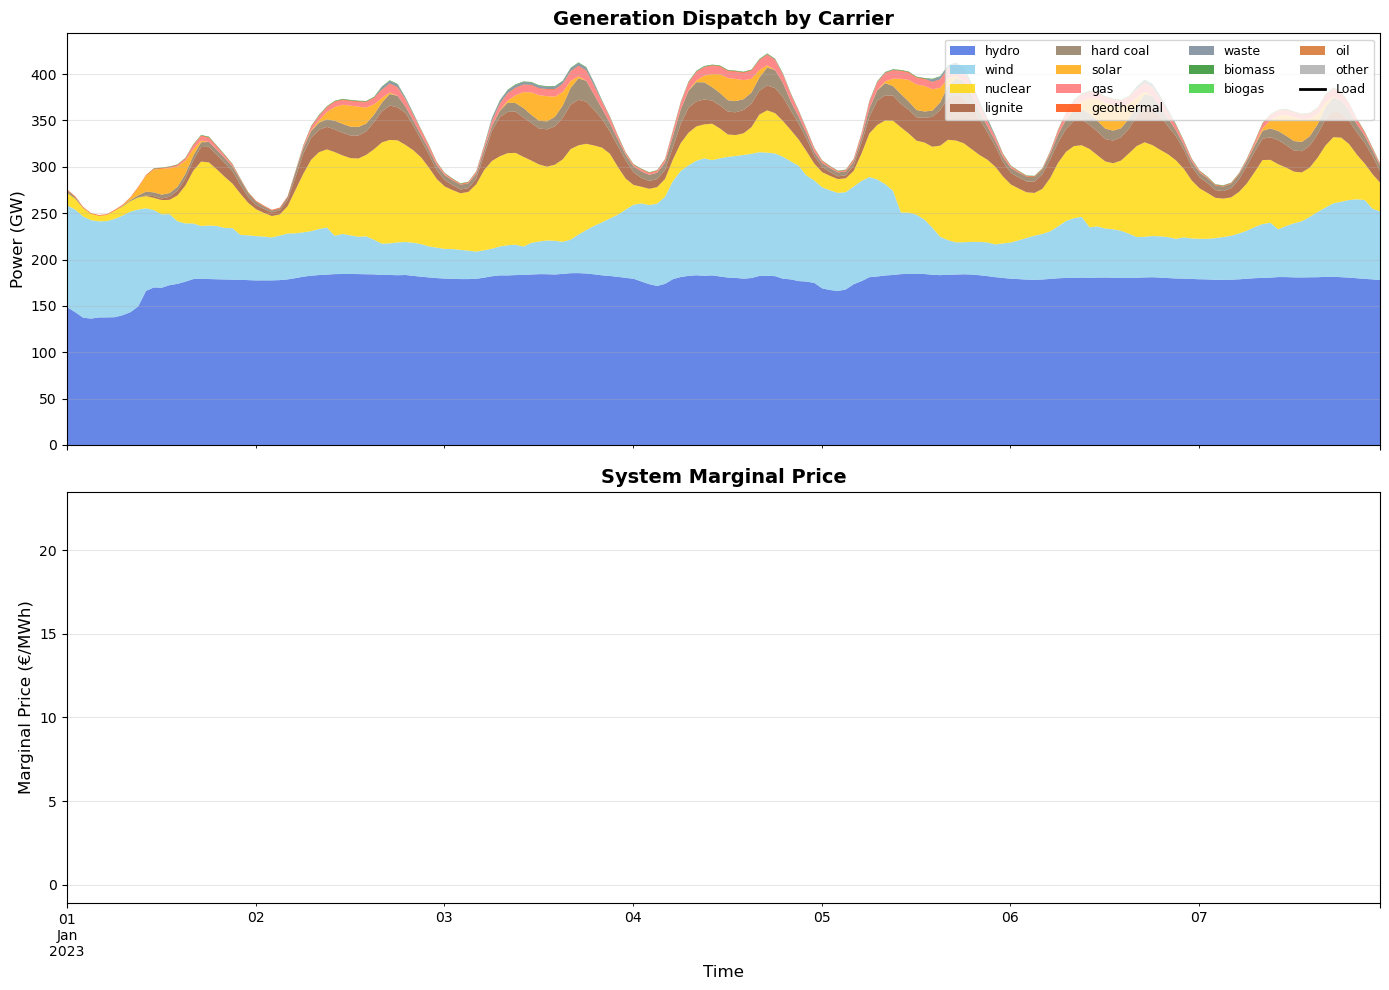

In [17]:
# =============================================================================
# VISUALIZE GENERATION MIX
# =============================================================================

if status == 'ok':
    # Carrier colors
    CARRIER_COLORS = {
        'hydro': '#4169E1',
        'nuclear': '#FFD700',
        'wind': '#87CEEB',
        'solar': '#FFA500',
        'gas': '#FF6B6B',
        'hard coal': '#8B7355',
        'lignite': '#A0522D',
        'oil': '#D2691E',
        'biomass': '#228B22',
        'biogas': '#32CD32',
        'geothermal': '#FF4500',
        'waste': '#708090',
        'other': '#A9A9A9',
        'load_shedding': '#FF0000',
    }
    
    # Generation time series by carrier
    gen_ts = n_dispatch.generators_t.p.groupby(
        n_dispatch.generators.carrier, axis=1
    ).sum() / 1e3  # Convert to GW
    
    # Sort carriers by total generation
    carrier_order = gen_ts.sum().sort_values(ascending=False).index
    gen_ts = gen_ts[carrier_order]
    
    # Get colors
    colors = [CARRIER_COLORS.get(c, '#808080') for c in carrier_order]
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Stacked area plot
    ax1 = axes[0]
    gen_ts.plot.area(ax=ax1, color=colors, alpha=0.8, linewidth=0)
    
    # Add load
    total_load = n_dispatch.loads_t.p_set.sum(axis=1) / 1e3
    ax1.plot(total_load.index, total_load.values, 'k-', linewidth=2, label='Load')
    
    ax1.set_ylabel('Power (GW)', fontsize=12)
    ax1.set_title('Generation Dispatch by Carrier', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', ncol=4, fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Marginal prices
    ax2 = axes[1]
    avg_price = n_dispatch.buses_t.marginal_price.mean(axis=1)
    ax2.plot(avg_price.index, avg_price.values, 'b-', linewidth=1)
    ax2.fill_between(avg_price.index, avg_price.values, alpha=0.3)
    ax2.set_ylabel('Marginal Price (€/MWh)', fontsize=12)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_title('System Marginal Price', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

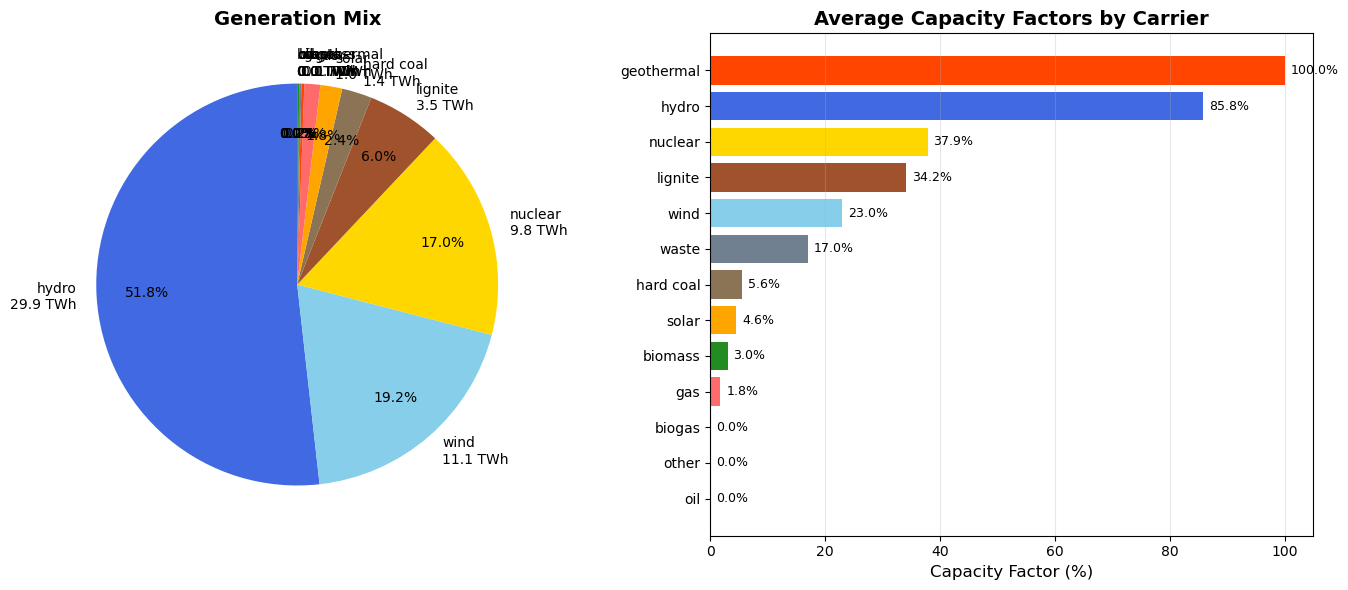

In [18]:
# =============================================================================
# GENERATION MIX PIE CHART & CAPACITY FACTORS
# =============================================================================

if status == 'ok':
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie chart of generation mix
    ax1 = axes[0]
    gen_totals = gen_by_carrier.sort_values(ascending=False)
    gen_totals = gen_totals[gen_totals > 0]  # Remove zeros
    colors = [CARRIER_COLORS.get(c, '#808080') for c in gen_totals.index]
    
    ax1.pie(
        gen_totals.values,
        labels=[f"{c}\n{v/1e6:.1f} TWh" for c, v in gen_totals.items()],
        colors=colors,
        autopct='%1.1f%%',
        pctdistance=0.75,
        startangle=90
    )
    ax1.set_title('Generation Mix', fontsize=14, fontweight='bold')
    
    # Capacity factors by carrier
    ax2 = axes[1]
    
    # Calculate capacity factors
    gen_cap = n_dispatch.generators.groupby('carrier').p_nom.sum()
    gen_energy = gen_by_carrier
    hours = len(n_dispatch.snapshots)
    
    cf = (gen_energy / (gen_cap * hours)).dropna()
    cf = cf[cf.index.isin(gen_by_carrier[gen_by_carrier > 0].index)]
    cf = cf.sort_values(ascending=True)
    
    colors = [CARRIER_COLORS.get(c, '#808080') for c in cf.index]
    bars = ax2.barh(cf.index, cf.values * 100, color=colors)
    ax2.set_xlabel('Capacity Factor (%)', fontsize=12)
    ax2.set_title('Average Capacity Factors by Carrier', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar, val in zip(bars, cf.values):
        ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{val*100:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 7. CO2 Emissions Analysis

In [19]:
# =============================================================================
# CO2 EMISSIONS ANALYSIS
# =============================================================================

if status == 'ok':
    print("CO2 EMISSIONS ANALYSIS")
    print("="*50)
    
    total_emissions = 0
    emissions_by_carrier = {}
    
    for carrier, factor in CO2_FACTORS.items():
        if carrier in gen_by_carrier.index:
            generation_mwh = gen_by_carrier[carrier]
            emissions = generation_mwh * factor / 1e6  # Mt CO2
            emissions_by_carrier[carrier] = emissions
            total_emissions += emissions
    
    print(f"\nEmissions by carrier (Mt CO2):")
    print("-"*40)
    for carrier, emissions in sorted(emissions_by_carrier.items(), key=lambda x: x[1], reverse=True):
        print(f"  {carrier:15s}: {emissions:8.3f} Mt")
    
    print(f"\n  {'TOTAL':15s}: {total_emissions:8.3f} Mt CO2")
    
    # Emission intensity
    emission_intensity = total_emissions * 1e6 / (total_gen / 1e3)  # kg CO2/MWh
    print(f"\nEmission intensity: {emission_intensity:.1f} kg CO2/MWh")

CO2 EMISSIONS ANALYSIS

Emissions by carrier (Mt CO2):
----------------------------------------
  lignite        :    4.084 Mt
  hard coal      :    1.281 Mt
  gas            :    0.295 Mt
  oil            :    0.000 Mt

  TOTAL          :    5.659 Mt CO2

Emission intensity: 97.9 kg CO2/MWh


## 8. Save Results

In [20]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

results_dir = results_path / "optimization"
results_dir.mkdir(parents=True, exist_ok=True)

if status == 'ok':
    # Save optimized network
    dispatch_file = results_dir / "network_dispatch_optimized.nc"
    n_dispatch.export_to_netcdf(dispatch_file)
    print(f"✓ Saved dispatch network: {dispatch_file}")
    
    # Save summary statistics
    summary = {
        'total_cost_EUR': n_dispatch.objective,
        'total_generation_MWh': total_gen,
        'total_emissions_tCO2': total_emissions * 1e6,
        'avg_marginal_price_EUR_MWh': avg_price.mean(),
        'congested_lines': congested,
        'snapshots': len(n_dispatch.snapshots),
    }
    
    summary_df = pd.Series(summary)
    summary_df.to_csv(results_dir / "dispatch_summary.csv")
    print(f"✓ Saved summary statistics")
    
    print(f"\n{'='*50}")
    print("OPTIMIZATION COMPLETE")
    print(f"{'='*50}")
    print(f"Total cost: {n_dispatch.objective/1e6:.2f} M€")
    print(f"Total generation: {total_gen/1e6:.2f} TWh")
    print(f"CO2 emissions: {total_emissions:.2f} Mt")
else:
    print("⚠ Optimization did not succeed - results not saved")

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/optimization/network_dispatch_optimized.nc contains: carriers, lines, links, generators, sub_networks, loads, buses


✓ Saved dispatch network: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/optimization/network_dispatch_optimized.nc
✓ Saved summary statistics

OPTIMIZATION COMPLETE
Total cost: 277.29 M€
Total generation: 57.83 TWh
CO2 emissions: 5.66 Mt


## 9. Conclusion

This notebook successfully:
1. Loaded the prepared European power system network
2. Applied connectivity fixes (bidirectional links)
3. Ran dispatch optimization
4. Analyzed the generation mix, costs, and emissions
5. Saved results for further analysis

**Key findings from this run:**
- Generation mix dominated by [see results above]
- CO2 emissions: [see results above]
- Line congestion: [see results above]